In [1]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import random

In [2]:
# Code to upload dataset to google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

path_to_zip_file = 'drive/MyDrive/data.zip'
directory_to_extract_to = 'VISCHEMA_PLUS/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
!cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
!cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"

In [2]:
import pandas as pd

class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])

batch_size = 8

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


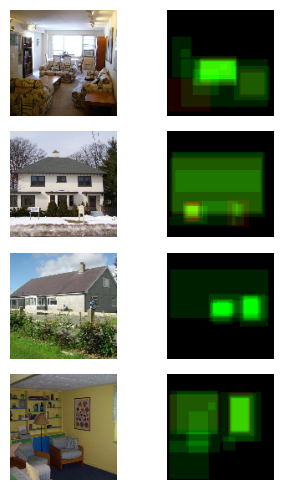

In [3]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm = True):
        super().__init__()
        if batch_norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.InstanceNorm2d(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.InstanceNorm2d(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.InstanceNorm2d(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512)):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], batch_norm = (i != 0)) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        
        for block in self.encoding_blocks:
            x = block(x)
            x = self.pool(x)
                 
        return x
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64,3)):
        
        super().__init__()
        
        self.channels = channels
        
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)]
        )
        
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i+1], channels[i+1]) for i in range(len(channels)-1)]
        )
    
    def forward(self, x):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512), 
                 decode_channels=(512,256,128,64,3), 
                 num_class=3):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels)
        self.decoder = Decoder(decode_channels)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        output = self.head(x)
        output = nn.Tanh()(output)
        
        return output

model = Generator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet Generator')

images, labels = next(iter(train_loader))
output = model(images)
print(output.shape)
print(labels.shape)
del model, output, images, labels

6924087 Parameters in UNet Generator
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_channels, out_channels, norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4,stride=2, padding=1)]
            if norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(6, 64, norm = False),
            *block(64, 128),
            *block(128,256),
            *block(256,512),
            *block(512,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512,1,4,padding=1, bias=False)
        )
        
    def forward(self, images, labels):
        
        image_input = torch.cat((images, labels), 1)
        return self.model(image_input)

model = Discriminator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Discriminator')

images, labels = next(iter(train_loader))
output = model(images, labels)
print(output.shape)

del model, output, images

6965440 Parameters in Discriminator
torch.Size([8, 1, 4, 4])


In [12]:
# Set up our training environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch = (1, 4, 4)

net_G = Generator()
net_D = Discriminator()

net_G, net_D = net_G.to(device), net_D.to(device)

criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss() 

train_losses = []
val_losses = []
best_val_loss = 1000000


# Loss weight of L1 pixel-wise loss between translated image and real image
# This value is copied from the PIX2PIX architecture
lambda_pixel = 100

optim_G = torch.optim.Adam(net_G.parameters(), lr=0.0001, betas = (0,0.9))
optim_D = torch.optim.Adam(net_D.parameters(), lr=0.0001, betas = (0,0.9))
num_epochs = 200

In [13]:
net_G.load_state_dict(torch.load("weights-NETG-4-175.pkl", map_location=torch.device('cpu')), strict=False)
net_D.load_state_dict(torch.load("weights-NETD-4-175.pkl", map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [9]:
print('Starting Training')
for epoch in range(175, 300):
    
    # Go into training mode
    net_D.train()
    net_G.train()
    
    # Train the model and evaluate on the training set
    total_train_loss = 0
    total_val_loss = 0

    for i, (images, real_labels) in enumerate(train_loader):

        # Adversarial ground truths
        valid = torch.ones((images.size(0), *patch)).to(device)
        fake = torch.zeros((images.size(0), *patch)).to(device)

        # Move images to device and create an image prediction
        images, real_labels = images.to(device), real_labels.to(device)
        
        ###################
        # Train Generator #
        ###################

        optim_G.zero_grad()
        
        # GAN Loss
        
        fake_labels = net_G(images)
        pred_fake = net_D(fake_labels, images)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(fake_labels, real_labels)
        
        # Logging
        batch_loss = loss_pixel.item() * batch_size
        total_train_loss += batch_loss
        
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        
        loss_G.backward()
        optim_G.step()

        #######################
        # Train Discriminator #
        #######################

        optim_D.zero_grad()
        
        # Real Loss
        pred_real = net_D(real_labels, images)
        loss_real = criterion_GAN(pred_real, valid)
        
        # Fake Loss
        pred_fake = net_D(fake_labels.detach(), images)
        loss_fake = criterion_GAN(pred_fake, fake)
        
        # Total Loss
        loss_D = 0.5 * (loss_real + loss_fake)
        
        loss_D.backward()
        optim_D.step()

        # Clear memory
        del images, real_labels, fake_labels 
        torch.cuda.empty_cache() 
    
    net_G.eval()
    with torch.no_grad():
      for i, (images, real_labels) in enumerate(val_loader):

          # Adversarial ground truths
          valid = torch.ones((images.size(0), *patch)).to(device)
          fake = torch.zeros((images.size(0), *patch)).to(device)

          # Move images to device and create an image prediction
          images, real_labels = images.to(device), real_labels.to(device)
          
          #########################
          # Test Generator On Val #
          #########################
          
          # GAN Loss
          
          fake_labels = net_G(images)
          loss_pixel = criterion_pixelwise(fake_labels, real_labels)
          batch_loss = loss_pixel.item() * batch_size
          total_val_loss += batch_loss

          # Clear memory
          del images, real_labels, fake_labels 
          torch.cuda.empty_cache() 

    train_losses.append( total_train_loss/ len(train_loader))
    val_losses.append( total_val_loss / len(val_loader))
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], D: {loss_D.item():.4f}, G: {loss_G.item():.4f},  Val Loss: {val_losses[-1]} Train Loss: {train_losses[-1]}')

    if val_losses[-1]< best_val_loss:
      torch.save(net_D.state_dict(), f'weights-NETD-4-best.pkl')
      torch.save(net_D.state_dict(), f'weights-NETG-4-best.pkl')
      print(f'saving weights for epoch: {epoch}')
      best_val_loss = val_losses[-1]

    if epoch % 25 == 0:
      torch.save(net_D.state_dict(), f'weights-NETD-4-{epoch}.pkl')
      torch.save(net_G.state_dict(), f'weights-NETG-4-{epoch}.pkl')

Starting Training
Epoch [1/200], D: 0.0286, G: 95.0287,  Val Loss: 7.372657728195191 Train Loss: 7.568341994285584
saving weights for epoch: 0
Epoch [2/200], D: 0.0103, G: 93.1066,  Val Loss: 7.192336928844452 Train Loss: 7.307571291923523
saving weights for epoch: 1
Epoch [3/200], D: 0.0199, G: 85.5774,  Val Loss: 7.037108623981476 Train Loss: 7.140193569660187
saving weights for epoch: 2
Epoch [4/200], D: 0.0053, G: 89.6839,  Val Loss: 6.899169397354126 Train Loss: 6.987492051720619
saving weights for epoch: 3
Epoch [5/200], D: 0.0071, G: 86.4042,  Val Loss: 6.7534901857376095 Train Loss: 6.8386875748634335
saving weights for epoch: 4
Epoch [6/200], D: 0.0077, G: 84.1757,  Val Loss: 6.61877144575119 Train Loss: 6.691800916194916
saving weights for epoch: 5
Epoch [7/200], D: 0.0026, G: 83.1054,  Val Loss: 6.486859822273255 Train Loss: 6.548335364460945
saving weights for epoch: 6
Epoch [8/200], D: 0.0042, G: 80.9721,  Val Loss: 6.358015286922455 Train Loss: 6.407381862401962
saving we

Epoch [66/200], D: 0.0004, G: 22.2098,  Val Loss: 2.1761639773845673 Train Loss: 1.7181763514876365
saving weights for epoch: 65
Epoch [67/200], D: 0.0010, G: 21.3130,  Val Loss: 2.156660610437393 Train Loss: 1.6892518006265163
saving weights for epoch: 66
Epoch [68/200], D: 0.0006, G: 22.7591,  Val Loss: 2.1399148374795915 Train Loss: 1.6561366014182568
saving weights for epoch: 67
Epoch [69/200], D: 0.0003, G: 21.4215,  Val Loss: 2.12891508936882 Train Loss: 1.629355851560831
saving weights for epoch: 68
Epoch [70/200], D: 0.0016, G: 20.6781,  Val Loss: 2.1100344508886337 Train Loss: 1.6080886766314506
saving weights for epoch: 69
Epoch [71/200], D: 0.0005, G: 20.2619,  Val Loss: 2.079431626200676 Train Loss: 1.5796222813427447
saving weights for epoch: 70
Epoch [72/200], D: 0.0006, G: 19.9617,  Val Loss: 2.051770916581154 Train Loss: 1.5499404229223728
saving weights for epoch: 71
Epoch [73/200], D: 0.0003, G: 20.0608,  Val Loss: 2.037155792117119 Train Loss: 1.519963613897562
savin

Epoch [133/200], D: 0.0003, G: 7.7887,  Val Loss: 1.305040642619133 Train Loss: 0.5864058816805482
saving weights for epoch: 132
Epoch [134/200], D: 0.0003, G: 7.3115,  Val Loss: 1.3029124394059182 Train Loss: 0.5793071430176496
saving weights for epoch: 133
Epoch [135/200], D: 0.0003, G: 9.7330,  Val Loss: 1.2977961719036102 Train Loss: 0.5741049205884338
saving weights for epoch: 134
Epoch [136/200], D: 0.0004, G: 7.8352,  Val Loss: 1.308987358212471 Train Loss: 0.5711143622174859
Epoch [137/200], D: 0.0002, G: 7.1379,  Val Loss: 1.2967055931687355 Train Loss: 0.5641807828098535
saving weights for epoch: 136
Epoch [138/200], D: 0.0003, G: 8.0366,  Val Loss: 1.2882283940911292 Train Loss: 0.5582995899021626
saving weights for epoch: 137
Epoch [139/200], D: 0.0008, G: 7.2453,  Val Loss: 1.2958238482475282 Train Loss: 0.5556397700682283
Epoch [140/200], D: 0.0001, G: 7.8705,  Val Loss: 1.2874071583151818 Train Loss: 0.5491735663264989
saving weights for epoch: 139
Epoch [141/200], D: 0.

In [15]:
torch.save(net_D.state_dict(), f'weights-NETD-4-{epoch}.pkl')
torch.save(net_G.state_dict(), f'weights-NETG-4-{epoch}.pkl')

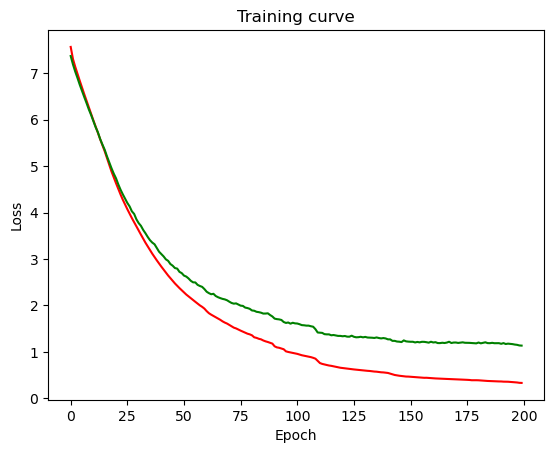

In [10]:
plt.title("Training curve")

plt.plot(range(len(train_losses)),train_losses,'r')
plt.plot(range(len(val_losses)),val_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

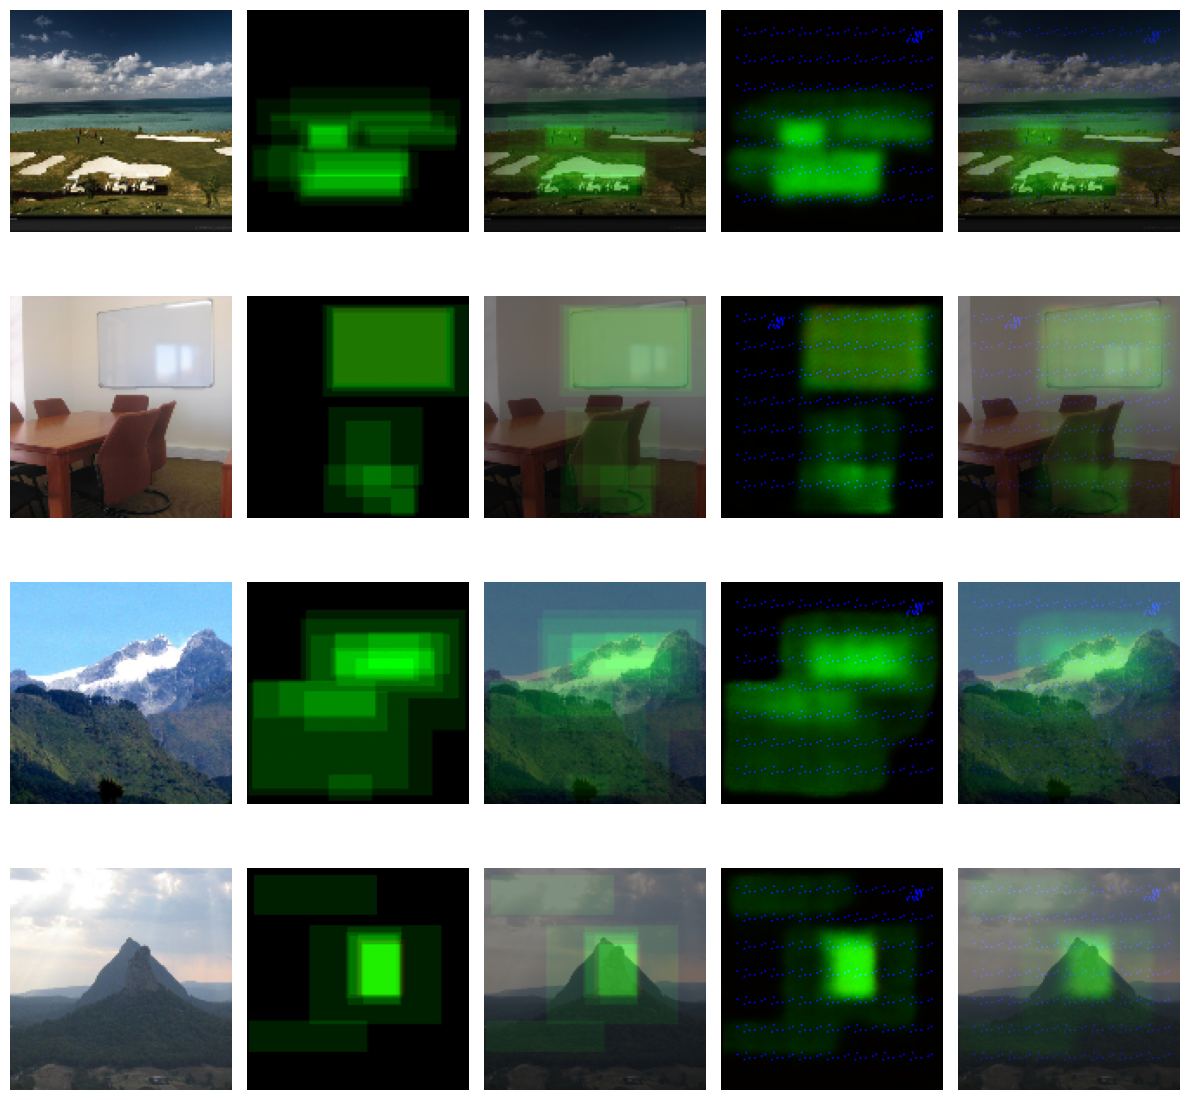

In [16]:
# Visualise Output
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
figure = plt.figure(figsize=(12,12))
output = net_G(images)

cols, rows = 5, 4
for i in range(rows):

    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )
    
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  

    figure.add_subplot(rows,cols, cols*i+3)
    plt.axis("off")
    plt.imshow(((torch.add(images, labels))[i].cpu().detach().squeeze().permute(1, 2, 0) +2 )/ 4 )

    figure.add_subplot(rows,cols, cols*i+4)
    plt.axis("off")
    plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  

    figure.add_subplot(rows,cols, cols*i+5)
    plt.axis("off")
    plt.imshow(((torch.add(images, output))[i].cpu().detach().squeeze().permute(1, 2, 0) +2 )/ 4 )
plt.tight_layout()
plt.show()